
<br>

# The VQLS (Variational Quantum Linear Solver) Algorithm  

#  Global Cost funcion

<br>

This notebook sheds light onto the basic mathematical principles underlying the Variational Quantum Linear Solver (VQLS), illustrates its implementation, and shows how to formulate it as a custom Qiskit program. 



The VQLS algorithm utilizes the VQE in order to solve the linear system of equations. If we are given a matrix $A$, such that $Ax = b$, where $b$ is some known vector then VQLS algorithm is able to find a normalized state $|x\rangle$ that is proportional to $x$.
 

There are two different ways to realize this algorithm: 
<br>

(i) with a global cost function 

(ii) with a local cost function.
<br>

We will look into each of the approaches by learning the mathmatical theory and solve the equation.

Sources and Links [also this notebook is built on] : 

- <a href="https://pennylane.ai/qml/demos/tutorial_vqls.html">Pennylane documentation</a>
- <a href="https://qiskit.org/textbook/ch-paper-implementations/vqls.html">Qiskit textbook</a>
- <a href="https://github.com/Qiskit-Partners/qiskit-runtime/tree/main/tutorials/sample_vqe_program">Qiskit VQE Runtime implementation</a>
- <a href="https://arxiv.org/pdf/1909.05820.pdf">Initial publication on the VQLS algorithm by Bravo-Prieto et al.</a>
- <a href="https://link.springer.com/content/pdf/10.1007/s11128-021-03140-x.pdf">Discussion of different classical optimizers for (noisy) variational quantum algorithms</a>

Figure 1: Idea and strucutre of the VQLS Algorithm. The figure is taken from <a href="https://arxiv.org/pdf/1909.05820.pdf">Bravo-Prieto et al.</a> 

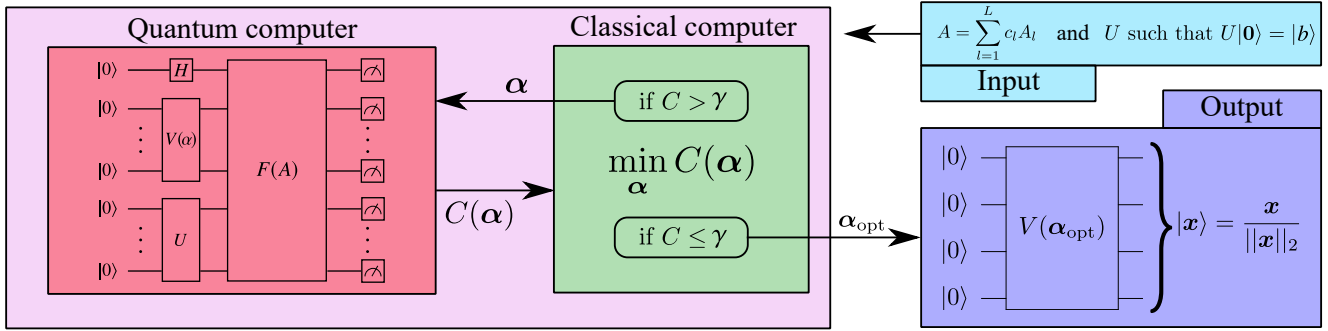

In [5]:
from IPython.display import Image
Image(r"Images/VQLS-block.png")

 We begin with a qubit register, with each qubit set to 0. Our approach starts by creating some ansatz V and then prepares and evaluates the cost function based on the inputs. If the computed cost exceeds some parameter, the procedure is repeated with updated parameters; otherwise, the algorithm ends and the ansatz is calculated with the optimal parameters (determined at termination). This produces the state vector that minimizes our cost function, and so the normalized form of x.

There are totally seven steps in the algorithm grouped into four processes. 

<br>
Input:
<br>

The idea behind the VQLS algorithm is how much a vector is in parallel with the <other vector. In this scenario, they are ($\vec{b}$) and ($A\vec{x}$). The idea is inspired from the dot product of the two vectors, as it is defined as $\vec{a} \cdot \vec{b}= |a| |b|  cos\theta$, where $\theta$ is the angle between the two vecors $\vec{a}$ and $\vec{b}$. The dot product is maximum when they are parallel ($\theta = 0 \degree$) and minimum when they are perpendicular ($\theta = 90 \degree$) to each other. 

(i) $A = \sum_m c_m A_m$ writing the matrix $A$ in terms of linear combination of unitaries

(ii) $b=U |0 \rangle$, loading vector $b$ by unitary acting on $|0\rangle$

<br>

Variational Circuit:
<br>

(iii) $|x(\alpha)\rangle_{var} = V_{var}(\alpha) |0\rangle $, preparing ansatz using $V_{var}(\alpha)$ circuit. The parameters $\alpha$
are input to a quantum computer, which prepares $|x(\alpha)\rangle$ and runs an efficient quantum circuit that estimates a
cost function $C(\alpha)$. We are trying to find $|x\rangle$ such that it satisfies $A|x\rangle = b$. So it is very important to choose the proper ansatz to increase the success of the algorithm.

(iv) $|\psi(\alpha) \rangle = A |x(\alpha)\rangle$ is the quantum state which is proportinal to $b$

<br>

Minimization of cost function:
<br>

(v) We use $C(\alpha) = \langle \psi(\alpha)|H| \psi(\alpha)\rangle = 1-|\langle b| \psi (\alpha) \rangle|^2$ as the cost function because it is $0$ when $|b\rangle$ and $|\psi(\alpha)\rangle$ are parallel and $1$ if they are perpendicular. Where $H$ is the hamiltonian of the system.

(vi) We use classical optimizer to minimizethe cost function ($min_{\alpha} C(\alpha)$) as a function of $\alpha$

<br>

Output:

<br>

(vii) $|\mathrm{x(\alpha)} \rangle _{opt}$ is the possible solution with the classically optimized parameters $\alpha_{opt}$


Given the intuition behind the algorithm, we go ahead and look into the assumptions made in VQLS algorithm.

Assumptions:

- Matrix A is square invertible (condition number $\kappa < \infty$)
- The vector $\vert b \rangle = U \vert 0 \rangle$ can be efficiently (hardware-efficient) prepared on the QC, in particular $\vec{b} \neq 0$
- Matrix A can be decomposed into a <b> polynomial </b> linear combination of L unitaries $A=\sum_{m} c_m A_m$
- Trial vectors $\vert x_0 \rangle = V(\alpha) \vert 0 \rangle $ can be efficiently (hardware-efficient) prepared 

Importing all the libraries needed to run the program

In [42]:
# Grab functions and modules from dependencies
import math
import numpy as np
from scipy.optimize import minimize, fmin_cg, OptimizeResult
from scipy.sparse import csr_matrix
from qiskit.algorithms.optimizers import SPSA
import mthree
from scipy.sparse import random
from scipy import stats
from numpy.random import default_rng
from numpy import linalg as LA

#from collections.abc import Iterable
import functools
import inspect
import itertools
#import numbers
from operator import matmul

# Grab functions and modules from Qiskit needed
import qiskit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, transpile, Aer, assemble
from qiskit.circuit import ParameterVector
import qiskit.circuit.library.n_local as lib_local
from qiskit.circuit import Gate

#from qiskit.providers.aer import UnitarySimulator
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_bloch_multivector

#from qiskit.opflow import X, Y, Z, Zero, One, I
from qiskit.quantum_info.operators.symplectic.pauli_list import PauliList
from qiskit.quantum_info.operators.symplectic.pauli import Pauli

from qiskit.quantum_info import SparsePauliOp

from qiskit.circuit.library import EfficientSU2, TwoLocal, NLocal, PauliTwoDesign
#from qiskit_nature.circuit.library import UCCSD, PUCCD, SUCCD

from qiskit.providers.ibmq.runtime import UserMessenger

# Plotting
import matplotlib.pyplot as plt
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from qiskit import IBMQ

from typing import List, Union

<b>First Step</b>: 

- Decompose the matrix $A  = \sum \limits_{m} c_m A_m$ in a Pauli String (string of pauli operators) (# qubits = n)

\begin{align*}
A =\sum \limits_{j_1,j_2,\dots,j_n} h_{j_1,j_2,\dots,j_n} \sigma_{j_1} \otimes \sigma_{j_2} \otimes \dots \otimes \sigma_{j_n} \\
\mathrm{with} \quad h_{j_1,j_2,\dots,j_n} = \dfrac{1}{2^n} \mathrm{Tr} \left[ \left( \sigma_{j_1} \otimes \sigma_{j_2} \otimes \dots \otimes \sigma_{j_n} \right) A \right] \\
\end{align*}
$\sigma_{j_n}$ is a Pauli operator acting on the $n^{th}$ qubit and $\mathrm{Tr}$ is the Trace of the matrix

<br>



- Prepare state $\vert b \rangle $ by applying unitary operator on the $\vert 0 \rangle $ state giving us $\vert b \rangle = U \vert 0 \rangle $ with an initial quantum circuit




A square matrix can be decomposed into linear combination of pauli operators, with coefficients.

In [44]:
rng = default_rng()
rvs = stats.poisson(1, loc=1).rvs
S = random(4, 4, density=0.1, random_state=rng, data_rvs=rvs)
mat= S.A

print(f'Matrix = \n {mat}')

decomp = SparsePauliOp.from_operator(mat)
print(f'Decomposion = \n {decomp}')
print('')

coeffs = decomp.coeffs
PO_list = decomp.paulis

print('With coefficients:')
print(coeffs)
print('')
print('of the Pauli combination:')
print(PO_list)

Matrix = 
 [[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]]
Decomposion = 
 SparsePauliOp(['II', 'IZ', 'XI', 'XZ', 'YI', 'YZ', 'ZI', 'ZZ'],
              coeffs=[ 0.25+0.j  , -0.25+0.j  ,  0.25+0.j  ,  0.25+0.j  ,  0.  -0.25j,
  0.  -0.25j, -0.25+0.j  ,  0.25+0.j  ])

With coefficients:
[ 0.25+0.j   -0.25+0.j    0.25+0.j    0.25+0.j    0.  -0.25j  0.  -0.25j
 -0.25+0.j    0.25+0.j  ]

of the Pauli combination:
['II', 'IZ', 'XI', 'XZ', 'YI', 'YZ', 'ZI', 'ZZ']


Since $A_m, U, A_m^{\dag}$ are the terms in the above expextation value. We can look at them one by one and build the quantum circuit for each of them.  

$A_m$ takes in the input of number of qubits, PauliList of pauli operators and idx to select the pauli operator string. 

We get the quantum circuit with the number of qubits needed and with the Pauli gates applied on each of the qubit and we then convert the quantum circuit to gate.

In [43]:
def A_m(matrix_qubits: int, obs_list: PauliList, idx: int, to_gate=True):
    
    qc = QuantumCircuit(matrix_qubits)
    operators = obs_list[idx]
     
    for j in reversed(range(len(operators))): # reversed because qubits numbering in qsikit are in reverse order
       
        if operators[j] == Pauli('I'):
            None
        elif operators[j] == Pauli('X'):
            qc.x(j)
        elif operators[j] == Pauli('Y'):
            qc.y(j)
        elif operators[j] == Pauli('Z'):
            qc.z(j)
    
    return qc.to_gate(label="$A_m$") if to_gate else qc

Given the matrix, we decompose it and get the pauli operators list. We can use them build the quantum circuit for $A_m$. In the below example, we see that matrix is of $4*4$ dimension and the number of qubits required to buld the circuit are $2$, and the quantum circuit is built with the $ZY$ operators. 

Note: when we calculate the cost function, we have to build the circuit including all the operators not just $ZY$. This example serves as a mere illustration of $A_m$ quantum circuit

obs_list: coeffs:  ['II', 'IX', 'XX', 'YY', 'ZY', 'ZZ'] [ 1.81 +0.j    -0.405+0.j    -0.405+0.j    -0.405+0.j     0.   +0.405j
 -0.81 +0.j   ]


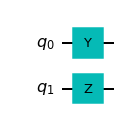

In [37]:
#matrix = np.eye(2)
matrix = np.array([[ 1,0,  0.  ,  0. ],
       [-0.81,  2.62, -0.81,  0. ,],
       [ 0.  , -0.81,  2.62, -0.81],
       [ 0.  ,  0.  , 0,1]])
pauli_op = SparsePauliOp.from_operator(matrix) 
coeffs = pauli_op.coeffs
obs_list = pauli_op.paulis
print ("obs_list:", "coeffs: ",obs_list,coeffs)
my_circ = A_m(2, obs_list, 4, to_gate=False)
my_circ.draw('mpl')

Since the $A_m$ circuit is going to be controlled operation for the hadamard test, let us look at the controlled quantum circuit with the transpilation done using backend.  

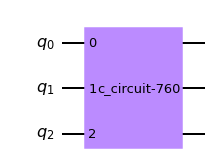

In [40]:
backend = Aer.get_backend('qasm_simulator') # using qasm simulator as backend. 
new_qc = QuantumCircuit(3) 
CA_gate = A_m(2, obs_list, 4, to_gate=False).control(1) # choosing the target bit (in this case its second bit) 
new_qc.append(CA_gate, [0, 1, 2]) # appending the A_m circuit to the new_qc
new_qc.draw('mpl')

Transpiled circuit is:

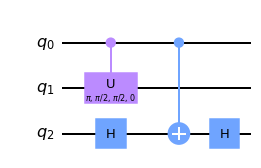

In [41]:
new_qc = transpile(new_qc, backend) # transpilation suing the backend
new_qc.draw('mpl')

$A_m^{\dagger}$ is the complex conjugate and transpose of the $A_m$. Similar to the $A_m$, here we obtain the quantum circuit with Pauli operators acting on each qubit and it is converted to the gate in the end. Below we see controlled complex conjugate matrix $(CA_m^{\dagger})$

In [44]:
def CA_m_dag(matrix_qubits: int, control_qubit: int, obs_list: PauliList, idx: int, to_gate=True):
    
    m_qubits = QuantumRegister(matrix_qubits, "matrix")
    c_qubit = QuantumRegister(1, "data")
    
    qc = QuantumCircuit(c_qubit, m_qubits)
    
    operators = obs_list[idx]
    
    for j in reversed(range(len(operators))):
        
        if operators[j] == Pauli('I'):
            None
        elif operators[j] == Pauli('X'):
            qc.cx(c_qubit, m_qubits[j])
        elif operators[j] == Pauli('Y'):
            qc.cy(c_qubit, m_qubits[j])
        elif operators[j] == Pauli('Z'):
            qc.cz(c_qubit, m_qubits[j])
    
    return qc.to_gate(label="$CA_m^\dag$") if to_gate else qc

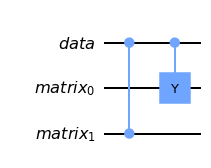

In [10]:
my_circ_dag = CA_m_dag(2, 0,obs_list, 4, to_gate=False)
my_circ_dag.draw('mpl')

Given any general vector $\vec{b}$, we use qiskit's method 'isometry' to convert the vector into input for the quantum circuit that generates $\vert b\rangle$. We then the transpile the vector circuit using appropriate gates at the backend.


In [45]:
def U_b(vector: np.array, to_gate=True):
    
    n = int(np.log2(len(vector)))
    qc = QuantumCircuit(n)
    qc.isometry(vector / np.linalg.norm(vector), list(range(n)), None)
    qc = transpile(qc, backend)
    
    return qc.to_gate(label="$U_b$") if to_gate else qc

<b> Second Step </b>:

- Define an appropriate ansatz for $\vert x (\alpha) \rangle =  V(\alpha) \vert 0 \rangle$ 

- The global cost function quantifies how much component $A\vert xx (\alpha)\rangle$ has orthogonal to $\vert b\rangle$ and the cost function is defined as follows:
<br>

\begin{align}
C_G ( \alpha )  = \dfrac{\langle \psi (\alpha) \vert H_b \vert \psi (\alpha) \rangle}{\langle \psi (\alpha) \vert \psi (\alpha) \rangle}
\end{align}

<br>

with $H_b = \mathbb{I} - \vert b \rangle \langle b \vert $, (where $\mathbb{I}$ is the Identity element) since 

<br>

\begin{align}
\dfrac{\langle \psi (\alpha) \vert H_b \vert \psi (\alpha) \rangle}{\langle \psi (\alpha) \vert \psi (\alpha) \rangle} = \dfrac{\langle \psi (\alpha) \vert \psi (\alpha) \rangle}{\langle \psi (\alpha) \vert \psi (\alpha) \rangle} -  \dfrac{\langle \psi (\alpha) \vert b \rangle  \langle b \vert \psi (\alpha) \rangle}{\langle \psi (\alpha) \vert \psi (\alpha) \rangle} = 1- \dfrac{\Big \vert \langle b \vert \psi (\alpha) \rangle \Big \vert^2}{\langle \psi (\alpha) \vert \psi (\alpha) \rangle}
\end{align}


<br>

which yields

- $ 0, \quad \mathrm{if} \quad \vert \psi(\alpha) \rangle \parallel \vert b \rangle $, or $1 \quad \mathrm{if} \quad \vert \psi(\alpha) \rangle \perp \vert b \rangle$
- It can also be between $0$ and $1$ depending on the overlap of the states

<br>

In what follows, we assume normalized quantum states $\langle \psi \vert \psi \rangle = \langle b \vert b \rangle = 1$. <br> In this case, for the global cost function, we need to evaluate the expectation value

\begin{align*}
\langle \psi (\alpha) \vert b \rangle  \langle b \vert \psi (\alpha) \rangle & = \langle x (\alpha) \vert A^\dagger \vert b \rangle  \langle b \vert A \vert x (\alpha) \rangle    \\&=
\langle 0 \vert V^\dagger (\alpha) A^\dagger \vert b \rangle  \langle b \vert A V (\alpha) \vert 0 \rangle & 
 \\&= \langle 0 \vert V^\dagger (\alpha) A^\dagger U \vert 0 \rangle  \langle 0 \vert U^\dagger A V (\alpha) \vert 0 \rangle
\end{align*}

$\dots$ with Pauli decomposition

\begin{align*}
\langle \psi (\alpha) \vert b \rangle  \langle b \vert \psi (\alpha) \rangle & = \sum \limits_{m,n} c_m^\ast c_n \langle 0 \vert V^\dagger (\alpha) A_m^\dagger U \vert 0 \rangle  \langle 0 \vert U^\dagger A_n V (\alpha) \vert 0 \rangle
\end{align*}

where $c_m^*$ and $c_n$ are the coefficients of the expansion of the matrix $(A)$

How to evaluate these expectation values?


## Hadamard test


Expectation values of the form $ \mu = \langle \psi \vert U \vert \psi \rangle $ can be calcualted via the <b>Hadamard test</b>. <br>

- The Hadamard test has the controlled unitary gate sandwitched between the Hadamard gates (Fig. 2), the target line of the circuit has the state that need to be evaluated. 

- The expectation value has both real and imaginary parts. We first look to get the real part of the expectation value:


Figure 2: Idea and strucutre of the Hadamard test (real part). The figure is taken from <a href="https://en.wikipedia.org/wiki/Hadamard_test_(quantum_computation)#:~:text=From%20Wikipedia%2C%20the%20free%20encyclopedia%20In%20quantum%20computation%2C,quantum%20state%20with%20respect%20to%20some%20unitary%20operator.">Wikipedia</a>.

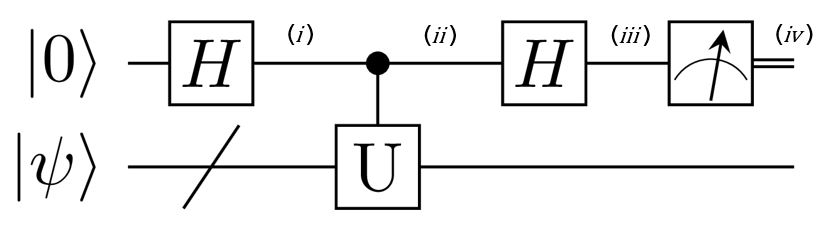

In [6]:

Image(r"C:\Users\mummanen\Pictures\Hadamard-test.jpeg")

\begin{align*}
\vert 0 \rangle \otimes  \vert  \psi \rangle & \overset{(i)}{\rightarrow}  {H} \vert 0 \rangle \otimes  \vert  \psi \rangle = \dfrac{1}{\sqrt{2}} \left(  \vert 0 \rangle + \vert 1 \rangle \right) \otimes \vert \psi \rangle  \quad \\ & \overset{(ii)}{\rightarrow} \dfrac{1}{\sqrt{2}} \left(  \vert 0 \rangle + \vert 1 \rangle \right) \otimes    {CU_{0,1}} \vert \psi \rangle  \quad =  \dfrac{1}{\sqrt{2}} \left(  \vert 0  \rangle \otimes  \vert  \psi \rangle + \vert 1 \rangle \otimes U \vert  \psi \rangle \right)   
\\ & \overset{(iii)}{\rightarrow} \dfrac{1}{\sqrt{2}} \left(   {H}  \vert 0  \rangle \otimes  \vert  \psi \rangle +   {H} \vert 1 \rangle \otimes U \vert  \psi \rangle \right)  =  \dfrac{1}{2} \left( \left[   \vert 0  \rangle + \vert 1  \rangle \right] \otimes  \vert  \psi \rangle + \left[   \vert 0  \rangle - \vert 1  \rangle \right] \otimes U \vert  \psi \rangle \right) \\
& \qquad \qquad \qquad \qquad \qquad \qquad \qquad \quad \ \ \  =\dfrac{1}{2} \left( \vert 0  \rangle \otimes \left[ \mathbb{I} + U \right]   \vert  \psi \rangle + \vert 1 \rangle \otimes \left[  \mathbb{I}  - U \right]  \vert  \psi \rangle \right) 
\end{align*}


$\dots$ substracting the measurement results <b> of the ancilla </b>, then leads to:


\begin{align*}
 {P(0)-P(1)} & = \Big \vert \Big \vert \, [\mathbb{I} + U] \vert \psi \rangle \, \Big \vert \Big \vert^2 - \Big \vert \Big \vert \, [\mathbb{I} - U] \vert \psi \rangle \, \Big \vert \Big \vert^2 = \dfrac{1}{4} \langle \psi \vert [\mathbb{I} + U]^\dagger [\mathbb{I} + U] \vert \psi \rangle - \dfrac{1}{4}\langle \psi \vert [\mathbb{I} - U]^\dagger [\mathbb{I} - U] \vert \psi \rangle \\
&= \dfrac{1}{4} \langle \psi \vert [\mathbb{I}^2 + U + U^\dagger + U^\dagger U ] \vert \psi \rangle - \dfrac{1}{4} \langle \psi \vert [\mathbb{I}^2 - U - U^\dagger + U^\dagger U ] \vert \psi \rangle \\
&= \dfrac{1}{2} \langle \psi \vert [U + U^\dagger] \vert \psi \rangle =  \dfrac{1}{2} \left( \langle \psi \vert U \vert \psi\rangle +\langle \psi \vert U \vert \psi\rangle^\ast\right) =   {\mathrm{Re} \langle \psi \vert U  \vert \psi \rangle}
\end{align*}

$\dots$ analogously, we can determine the imaginary part including another phase gate (rotation):

\begin{align*}
\vert 0 \rangle \otimes  \vert  \psi \rangle & \overset{(i)}{\rightarrow}   {P\left(-\frac{\pi}{2}\right) H} \vert 0 \rangle \otimes  \vert  \psi \rangle = \dfrac{1}{\sqrt{2}} \left(  \vert 0 \rangle - i \vert 1 \rangle \right) \otimes \vert \psi \rangle  \quad \\ 
& \overset{(ii)}{\rightarrow} \dfrac{1}{\sqrt{2}} \left(  \vert 0 \rangle - i \vert 1 \rangle \right) \otimes   {CU_{0,1}} \vert \psi \rangle  \quad =  \dfrac{1}{\sqrt{2}} \left(  \vert 0  \rangle \otimes  \vert  \psi \rangle - i \vert 1 \rangle \otimes U \vert  \psi \rangle \right)   
\\ & \overset{(iii)}{\rightarrow} \dfrac{1}{\sqrt{2}} \left(   {H}  \vert 0  \rangle \otimes  \vert  \psi \rangle -   {H} i \vert 1 \rangle \otimes U \vert  \psi \rangle \right)  =  \dfrac{1}{2} \left( \left[   \vert 0  \rangle + \vert 1  \rangle \right] \otimes  \vert  \psi \rangle - i \left[   \vert 0  \rangle - \vert 1  \rangle \right] \otimes U \vert  \psi \rangle \right) \\
& \qquad \qquad \qquad \qquad \qquad \qquad \qquad \quad \ \ \  =\dfrac{1}{2} \left( \vert 0  \rangle \otimes \left[ \mathbb{I} - i U \right]   \vert  \psi \rangle + \vert 1 \rangle \otimes \left[  \mathbb{I}  + i U \right]  \vert  \psi \rangle \right) 
\end{align*}

$\dots$ substracting the measurement results <b> of the ancilla </b>, then leads to:


\begin{align*}
 {P(0)-P(1)} & = \Big \vert \Big \vert \, [\mathbb{I} - i U] \vert \psi \rangle \, \Big \vert \Big \vert^2 - \Big \vert \Big \vert \, [\mathbb{I} + i U] \vert \psi \rangle \, \Big \vert \Big \vert^2 = \dfrac{1}{4} \langle \psi \vert [\mathbb{I} - i U]^\dagger [\mathbb{I} - i U] \vert \psi \rangle - \dfrac{1}{4}\langle \psi \vert [\mathbb{I} + i U]^\dagger [\mathbb{I} + i U] \vert \psi \rangle \\
&= \dfrac{1}{4} \langle \psi \vert [\mathbb{I}^2 - i U + i U^\dagger + U^\dagger U ] \vert \psi \rangle - \dfrac{1}{4} \langle \psi \vert [\mathbb{I}^2 + i U - i U^\dagger + U^\dagger U ] \vert \psi \rangle \\
&= \dfrac{1}{2} i \langle \psi \vert [U^\dagger - U] \vert \psi \rangle =  \dfrac{1}{2} i \left( \langle \psi \vert U \vert \psi\rangle^\ast - \langle \psi \vert U \vert \psi\rangle \right) = - i^2 \mathrm{Im} \langle \psi \vert U  \vert \psi \rangle =  {\mathrm{Im} \langle \psi \vert U  \vert \psi \rangle}
\end{align*}

$\dots$ hence, in total we can evaluate with this the entire (complex) expectation value

<br>

$$ \mu = \langle \psi \vert U \vert \psi \rangle  = \mathrm{Re} \langle \psi \vert U \vert \psi \rangle + i \, \mathrm{Im} \langle \psi \vert U \vert \psi \rangle $$

However, so far, our expectation value of interest does <b> not </b> have the simple form shown above, as

<br>

\begin{align*}
\langle \psi (\alpha) \vert b \rangle  \langle b \vert \psi (\alpha) \rangle & = \sum \limits_{m,n} c_m^\ast c_n \langle 0 \vert V^\dagger (\alpha) A_m^\dagger U \vert 0 \rangle  \langle 0 \vert U^\dagger A_n V (\alpha) \vert 0 \rangle
\end{align*}

Since there are three expectation values (two in numerator and one in denominator) to be evaluated in the global cost function, we name them accordingly:

\begin{align*}
\mathrm{expval1}  &= \langle 0 \vert V^\dagger (\alpha) A^\dagger U \vert 0 \rangle \\
\mathrm{expval2}  &= \langle 0 \vert U^\dagger A V (\alpha) \vert 0 \rangle \\
\mathrm{expval3}  &= \langle 0 \vert V^\dagger (\alpha) A^\dagger  A V (\alpha) \vert 0 \rangle
\end{align*}

In the above expectation values, we have the $V^{\dagger}$ and $U^{\dagger}$, therefore we can have a look at how to produce this circuits. So complex comjugate of the unitary operators are inverse of a quantum circuit for unitary operator. Below we see an example of an ansatz and also it's inverse.

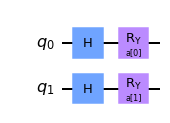

In [11]:
def custom_ansatz(num_qubits):
    
    circ = QuantumCircuit(num_qubits) # building the quantum circuit
    theta = ParameterVector('a', length = num_qubits) # initializing the parametere for the ansatz
    
    for idx in range(num_qubits):
        circ.h(idx)

    #A very minimal variational circuit.
    for idx in range(num_qubits):
        #print(idx, element)
        circ.ry(theta[idx], idx)
    
    return circ, len(theta)

ansatz_circuit, num_params = custom_ansatz(2)
ansatz_circuit.draw('mpl')

After transpiling tha ansatz on the backend, we obtain the following circuit.

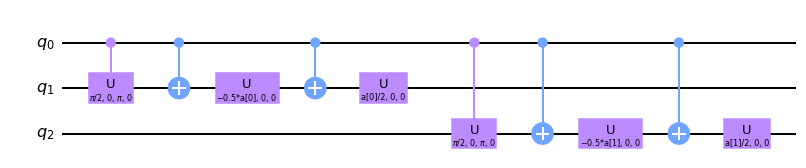

In [12]:
Ansatz_gate = ansatz_circuit.to_gate(label="ansatz")
CAnsatz_gate = Ansatz_gate.control(1) 

new_qc = QuantumCircuit(3)
new_qc.append(CAnsatz_gate, [0, 1, 2])

new_qc = transpile(new_qc, backend)
new_qc.draw('mpl')

we can easily get the inverse of the circuit by invoking the inverse function in the qiskit.

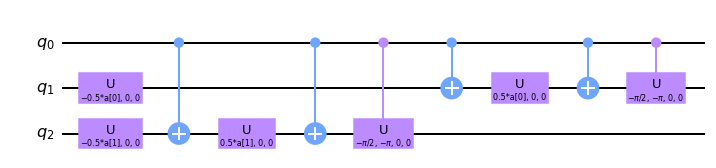

In [14]:
new_qc_inverse = transpile(new_qc, backend)
new_qc_inverse = new_qc_inverse.inverse()
new_qc_inverse.draw('mpl')

Similar procedure goes for $U^{\dagger}$. Building $U$ circuit and inversing the circuit, we obtain $U^{\dagger}$

In [46]:
def U_b(vector: np.array, to_gate:True):
    
    n = int(np.log2(len(vector)))
    qc = QuantumCircuit(n)
    qc.isometry(vector / np.linalg.norm(vector), list(range(n)), None)
    qc = transpile(qc, backend)
    
    return qc.to_gate(label="$U_b$") if to_gate else qc

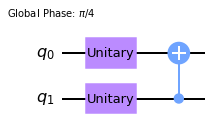

In [25]:
vector = np.ones(4)
my_circ1 = U_b(vector,to_gate=False)
my_circ1 = transpile(my_circ1, backend)
my_circ1.draw('mpl')

$U^{\dagger}$ circuit is:

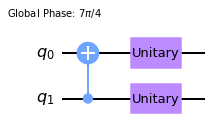

In [19]:
mycirc1_inv = my_circ1.inverse()
mycirc1_inv.draw('mpl')

 Having defined the prerequisites to calculate the expectation values, we are eqipped to handle them. First, we calculate the numerator expectation value $\langle 0 \vert V^\dagger (\alpha) A^\dagger U \vert 0 \rangle$

 - First we initialize the quantum circuit with registers
 - Hadamard gate would be applied on the data qubit
 - We check for the phase inlusion and apply phase gate if we are calculating imaginary part of the expectation value, otherwise do nothing
 - We then add the vector part $(U_b)$, controlled $A^\dagger$ and then we finally have $V^\dagger$ by introducing ansatz circuit
 - Final part is measurement based on the backend and the number of shots


In [56]:
def expval1(vector: np.array, ansatz: QuantumCircuit, obs_list: PauliList, matrix_qubits: int, control_qubit: int, lp: int,shots: int, backend, part: str):
    
    m_qubits = QuantumRegister(matrix_qubits, "matrix")
    c_qubit = QuantumRegister(1, "data")
    classical_bit = ClassicalRegister(1)
    qc = QuantumCircuit(c_qubit, m_qubits, classical_bit)
    
    #The first hadamard gate for the hadamard test
    qc.h(c_qubit)
    
    if part == "Im" or part == "im":
        qc.p(-np.pi / 2, c_qubit)

    qubit_list = [c_qubit]

    for s in range(matrix_qubits):
        qubit_list.append(m_qubits[s])
        
    # apply controlled U operator 
    controlled_Ub_gate = U_b(vector, to_gate = True).control(1) 
    qc.append(controlled_Ub_gate, qubit_list)
    
    # controlled A dagger
    qc.append(CA_m_dag(matrix_qubits, control_qubit, obs_list, lp, to_gate=False), qubit_list)
    
    # controlled ansatz with dagger V
    ansatz_circuit = ansatz.inverse()
    Ansatz_gate = ansatz_circuit.to_gate(label="$V^\dagger$")
    CAnsatz_gate = Ansatz_gate.control(1) 
    qc.append(CAnsatz_gate, qubit_list)
    
    # The final hadamard gate in hadamard test       
    qc.h(c_qubit)
    
    # measurement
    qc = transpile(qc, backend)
    qc.measure(c_qubit, classical_bit)
    job = backend.run(qc, shots=shots)
    result = job.result().get_counts()

    if len(result)==1:
        for s in result.keys():
            if s=='0':
                expectation = result['0']/shots
            if s=='1':
                expectation = -result['1']/shots
    else:        
        expectation = (result['0']-result['1'])/shots

    return qc,expectation

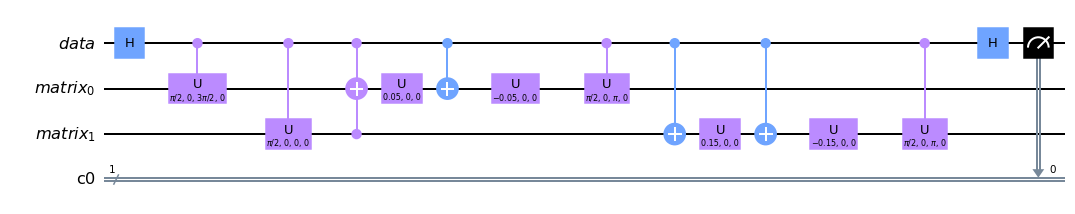

In [30]:
weights = np.array([0.1, 0.3])
ansatz = ansatz_circuit.bind_parameters(weights)
vector = np.ones(4)
alpha_real = expval1(vector, ansatz, obs_list, 2, 0, 1, 1024,backend,part = "re")
alpha_real[0].draw('mpl')

Second expectation value on the numerator of the cost function is $\langle 0 \vert U^\dagger A V (\alpha) \vert 0 \rangle$. The evaluation of this expectation value is similar to the first one, but the order of oprators is reversed.

In [48]:
def expval2(vector: np.array, ansatz: QuantumCircuit, obs_list: PauliList, matrix_qubits: int, control_qubit: int, l: int, shots: int,backend,part: str):
    
    m_qubits = QuantumRegister(matrix_qubits, "matrix")
    c_qubit = QuantumRegister(1, "data")
    classical_bit = ClassicalRegister(1)
    qc = QuantumCircuit(c_qubit, m_qubits, classical_bit)
    
    qc.h(c_qubit)
    
    if part == "Im" or part == "im":
        qc.p(-np.pi / 2, c_qubit)

    qubit_list = [c_qubit]

    for s in range(matrix_qubits):
        qubit_list.append(m_qubits[s])
        
    # controlled ansatz 
    Ansatz_gate = ansatz.to_gate(label="V")
    CAnsatz_gate = Ansatz_gate.control(1) 
    qc.append(CAnsatz_gate, qubit_list)
    
    # controlled A
    CA_gate = A_m(matrix_qubits, obs_list, l, to_gate=True).control(1) 
    qc.append(CA_gate, qubit_list)
        
    # apply controlled U dagger operator 
    Ub_circuit = U_b(vector, to_gate = False)
    Ub_circuit = Ub_circuit.inverse()
    Ub_gate = Ub_circuit.to_gate(label = '$Ub^\dagger$')
    controlled_Ub_gate = Ub_gate.control(1) 
    qc.append(controlled_Ub_gate, qubit_list)
    
    qc.h(c_qubit)
    
    # measurement
    qc = transpile(qc, backend)
    qc.measure(c_qubit, classical_bit)
    job = backend.run(qc, shots=shots)
    result = job.result().get_counts()

    if len(result)==1:
        for s in result.keys():
            if s=='0':
                expectation = result['0']/shots
            if s=='1':
                expectation = -result['1']/shots
    else:        
        expectation = (result['0']-result['1'])/shots

    return expectation

finally, the denominator of the cost function has the expectation value of the form $$
\langle \psi (\alpha) \vert \psi (\alpha) \rangle = \sum \limits_{m,n} c_m^\ast c_n \langle 0 \vert V^\dagger (\alpha) A_m^\dagger  A_n V (\alpha) \vert 0 \rangle $$ 

In [49]:
def expval3(ansatz: QuantumCircuit, obs_list: PauliList, matrix_qubits: int, control_qubit: int, l: int, lp: int,shots: int,backend, part: str):
    
    m_qubits = QuantumRegister(matrix_qubits, "matrix")
    c_qubit = QuantumRegister(1, "data")
    classical_bit = ClassicalRegister(1)
    qc = QuantumCircuit(c_qubit, m_qubits, classical_bit)
    
    # Variational circuit generating a guess for the solution vector |x>
    qc.append(ansatz, m_qubits)
    
    qc.h(c_qubit)
    
    if part == "Im" or part == "im":
        qc.p(-np.pi / 2, c_qubit)
        
    # prepare vector x using ansatz circuit
    qubit_list = [c_qubit]

    for s in range(matrix_qubits):
        qubit_list.append(m_qubits[s])

    # controlled A
    CA_gate = A_m(matrix_qubits, obs_list, l, to_gate=True).control(1) 
    qc.append(CA_gate, qubit_list)
    
    # controlled A dagger
    qc.append(CA_m_dag(matrix_qubits, control_qubit, obs_list, lp, to_gate=False), qubit_list)
    
    qc.h(c_qubit)
    
    # measurement
    qc = transpile(qc, backend)
    qc.measure(c_qubit, classical_bit)
    job = backend.run(qc, shots=shots)
    result = job.result().get_counts()

    if len(result)==1:
        for s in result.keys():
            if s=='0':
                expectation = result['0']/shots
            if s=='1':
                expectation = -result['1']/shots
    else:        
        expectation = (result['0']-result['1'])/shots

    return expectation

Let's use all the expectation values defined and finally combine them and write the main program. The explanation of step by by step code is given as follows:

- First, we determine the number of qubits based on the vector.
- The matrix is decomposed into a string of Pauli operatos along with the coefficients.
- To begin, we select the ansatz input, which can be either a user-created (Hardware-efficient) version or one of the predefined versions found in the qiskit library.

- Three expectation values are then computed.
- We compute the cost function by comparing the optimization routines requested by the user, such as SPSA versus SciPy, and dispatching to the appropriate optimizer. The chosen optimizer starts at x0 and calls 'global cost' every time the cost function needs to be evaluated. The outcome is a SciPy OptimizerResult object.
- Finally, we have the result, the cost function, and the quantum solution.

In [57]:
# The entrypoint for our Runtime Program
def main(backend, user_messenger,
         matrix,
         vector,
         ansatz,
         ansatz_config,
         ansatz_circuit,
         num_params,
         x0,
         optimizer,
         optimizer_config,
         shots,
        ):
    
    
    #determine number of qubits
    num_qubits = int(np.log2(len(vector))) # number of system qubits
    tot_qubits = num_qubits + 1  # Addition of an ancillary qubit
    ancilla_idx = 0 # Index of the ancillary qubit for the Hadamard test(last position)
    
    #Convert the matrix to Hamiltonian
    pauli_op = SparsePauliOp.from_operator(matrix) 
    coeffs = pauli_op.coeffs
    obs_list = pauli_op.paulis
    
    if ansatz=='custom':
        
        ansatz_circuit = ansatz_circuit
        num_params = num_params
        
    else: 
            
        # We grab the requested ansatz circuit class from the Qiskit circuit library
        # n_local module and configure it using the number of qubits and options
        # passed in the ansatz_config.
        ansatz_instance = getattr(lib_local, ansatz)
        ansatz_circuit = ansatz_instance(num_qubits, **ansatz_config)

        # Get the number of parameters in the ansatz circuit.
        num_params = ansatz_circuit.num_parameters
    
    # Use a given initial state, if any, or do random initial state.
    if x0:
        x0 = np.asarray(x0, dtype=float)
        if x0.shape[0] != num_params:
            raise ValueError('Number of params in x0 ({}) does not match number \
                              of ansatz parameters ({})'. format(x0.shape[0],
                                                                 num_params))
    else:
        x0 = 2*np.pi*np.random.rand(num_params)  
           


    
    # Here we define a callback function that will stream the optimizer parameter vector
    # back to the user after each iteration.  This uses the `user_messenger` object.
    # Here we convert to a list so that the return is user readable locally, but
    # this is not required.
        
    def callback(xk):
        user_messenger.publish(list(xk))
    
    def alpha(ansatz, lp=None):
        """Generates the coefficients to compute the "global" cost function C_G."""
        
        alpha_real = expval1(vector, ansatz, obs_list, num_qubits, ancilla_idx, lp, shots, backend,part = "re")
        alpha_imag = expval1(vector, ansatz, obs_list, num_qubits, ancilla_idx, lp, shots,backend,part = "im")
        
        return alpha_real[1] + 1.0j * alpha_imag[1]
    
    def beta(ansatz, l=None):
        """Generates the coefficients to compute the "global" cost function C_G."""

        beta_real = expval2(vector, ansatz, obs_list, num_qubits, ancilla_idx, l, shots,backend, part = "re") 
        beta_imag = expval2(vector, ansatz, obs_list, num_qubits, ancilla_idx, l,shots,backend, part = "im")
        
        return beta_real + 1.0j * beta_imag
    
    def gamma(ansatz, l = None, lp=None):
        """Generates the coefficients to compute the "global" cost function C_G."""

        gamma_real = expval3(ansatz, obs_list, num_qubits, ancilla_idx, l, lp,shots,backend, part = "re") 
        gamma_imag = expval3(ansatz, obs_list, num_qubits, ancilla_idx, l, lp,shots,backend, part = "im")
        
        return gamma_real + 1.0j * gamma_imag
        
    def global_cost(weights):
        """Global version of the cost function. Tends to zero when A|x> is proportional to |b>."""
        
        sum1 = 0.0
        sum2 = 0.0
        
        ansatz_circ = ansatz_circuit.bind_parameters(weights)

        for l in range(0, len(coeffs)):
            for lp in range(0, len(coeffs)):
                sum1 = sum1 + coeffs[l] * np.conj(coeffs[lp]) * alpha(ansatz_circ, lp)*beta(ansatz_circ, l)
                sum2 = sum2 + coeffs[l] * np.conj(coeffs[lp]) * gamma(ansatz_circ, l, lp)

        sum1 = abs(sum1)
        sum2 = abs(sum2)
        
        # Cost function C_G
        cf = 1 - sum1/sum2

        cost_function.append(cf)
     
        return cf
    
    # Here is where we actually perform the computation.  We begin by seeing what
    # optimization routine the user has requested, eg. SPSA verses SciPy ones,
    # and dispatch to the correct optimizer.  The selected optimizer starts at
    # x0 and calls 'global_cost' everytime the optimizer needs to evaluate the cost
    # function.  The result is returned as a SciPy OptimizerResult object.
    # Additionally, after every iteration, we use the 'callback' function to
    # publish the interm results back to the user. This is important to do
    # so that if the Program terminates unexpectedly, the user can start where they
    # left off.
    
    cost_function = []
    
    # Since SPSA is not in SciPy need if statement
    if optimizer == 'SPSA':
        opt = SPSA(maxiter=500)
        res = opt.minimize(global_cost,x0)
    # All other SciPy optimizers here
    else:
        res = minimize(global_cost, x0, method=optimizer,
                           options=optimizer_config, callback=callback)
    
    # Return result (res) is a subclass of dict.
    
    circ = ansatz_circuit.bind_parameters(res.x)
    circ.measure_all()
    
    t_circ = transpile(circ, backend)
    job = backend.run(t_circ, shots=shots)
    result = job.result()
    
    sorted_keys = sorted(result.get_counts())
    solution_probabilities = np.zeros(2**num_qubits)
    i=0
    for key in sorted_keys:
        solution_probabilities[i] = result.get_counts()[key]
        i=i+1

    o = solution_probabilities/shots
    
    # quantum probabilities to actual classical solution
    quantum_solution = np.sqrt(np.real(o))*np.linalg.norm(vector)
    
    return res, cost_function, quantum_solution

Here, we invoke the backend, in this case it is qasm_simulator. One can use the statevector_simulator, real backend or fake simulator IBM has to offer. 

In [51]:
backend = Aer.get_backend('qasm_simulator')
msg = UserMessenger()

matrix = np.eye(2)
vector = np.ones(2)

A_inv = np.linalg.inv(matrix)
classical_solution = np.dot(A_inv, vector)

This is the execution program, after running all the above cells, we can choose the inputs of the main function here. Inputs like matrix, vector, ansatz, intial parameters like ($x_0$), maximum iterations, or the choice of classical optimizer. 

<br>

After careful analysis of all the available optimizers from IBM qiskit, we have boiled down the two important optimizers: (i) Stochastic perturbative simulataneous algorithm (SPSA) and (ii) Constrained optimization by linear algorithm solvers (COBYLA). So, one can play around the optimizers. 

Note: Using higher number of shots will lead to higher accuracy of a result but takes long time 


In [64]:
# Execute the main routine for our sparseMatrix and vector
# Try another qiskit ansatz: EfficientSU2, TwoLocal, NLocal, PauliTwoDesign, UCCSD, PUCCD, SUCCD
# Or another scipy optimizer: SPSA, Nelder-Mead, Powell, CG, BFGS, Newton-CG, L-BFGS-B, TNC, COBYLA, SLSQP etc.

# for Qiskit ansatz

result, cost_fn, quantum_solution = main(backend, msg,
                                         matrix,
                                         vector,
                                         ansatz='EfficientSU2',
                                         #ansatz_config={'reps': 1, 'entanglement': 'linear', 'rotation_blocks': ['ry', 'rz'], 'entanglement_blocks': 'cx'},
                                         ansatz_config={'reps': 1, 'entanglement': 'linear'},
                                         ansatz_circuit = None,
                                         num_params = None,
                                         x0=None,
                                         optimizer='COBYLA',
                                         optimizer_config={'maxiter': 200},
                                         shots = 1024*4,
                                        )

c:\Users\mummanen\Anaconda3\lib\site-packages\scipy\optimize\_minimize.py:548: RuntimeWarning: Method COBYLA does not support callback.
  warn('Method %s does not support callback.' % method, RuntimeWarning)


Once our program execution is done, we now look at the results. First, we have a look at the optimization of the cost function and then comparison between classical and quantum solution.
<br>

 The optimization of the cost function with respect to the number of iterations are shown below.

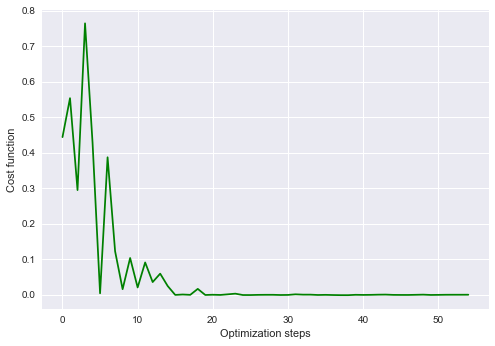

In [65]:
plt.style.use("seaborn")
plt.plot(cost_fn, "g")
plt.ylabel("Cost function")
plt.xlabel("Optimization steps")
plt.show()

The classical and the quantum solutions of the system are compared below. 

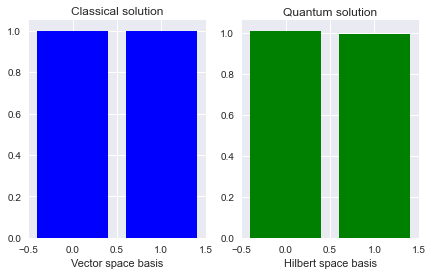

In [66]:
A_inv = np.linalg.inv(matrix)
classical_solution = np.dot(A_inv, vector)

#plotting
num_qubits = int(np.log2(len(vector)))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 4))

ax1.bar(np.arange(0, 2 ** num_qubits), classical_solution, color="blue")
ax1.set_xlim(-0.5, 2 ** num_qubits - 0.5)
ax1.set_xlabel("Vector space basis")
ax1.set_title("Classical solution")

ax2.bar(np.arange(0, 2 ** num_qubits), quantum_solution, color="green")
ax2.set_xlim(-0.5, 2 ** num_qubits - 0.5)
ax2.set_xlabel("Hilbert space basis")
ax2.set_title("Quantum solution")

plt.show()

Therefore, we completed the theory and the implementation of the Global cost function.